## Descripción e identificación del tipo de algoritmo
Se trata de un **algoritmo de regresión** ya que intenta explicar una variable continua, $y$. En concreto, para cada ejemplo disponible, se intenta explicar $y$ como una combinación lineal de un conjunto de características:

$$\hat{y} = w_0 + w_1x_1 + w_2 x_2  + \ldots + w_m x_M,$$
donde:
- $\hat{y}$ denota el valor estimado de $y$ obtenido por el algoritmo.
- $w_m, m \in [0,M]$ denotan el conjunto de pesos asignados a cada característica aprendidos por el algoritmo. Se trata, por tanto, de un **modelo parámetrico** donde los pesos son los parámetros. 
- $x_m, m \in [0,M]$, denotan cada una de las características de los datos de entrada.

Para obtener el valor óptimo de los pesos, se minimiza una función de coste que mide el error cometido con respecto a la variable $y$ original. Esto lo convierte en un **algoritmo supervisado** ya que hace uso de un valor conocido de la variable objetivo. En concreto la función de coste que se presente optimizar es la siguiente:

$$J = \sum \left[ (y-\hat{y})^2 + \alpha  \sum_{m=0}^M | w_m| \right]$$ 

donde el sumatorio de la izquierda recorre todos los datos disponibles en nuestro conjunto de entrenamiento y $\alpha$ es un **factor de regularización** que penaliza la complejidad del mismo para evitar el sobreajuste.
$\alpha$ es, por tanto, también un **hiperparámetro del modelo** ya que lo debemos fijar antes del proceso de entrenamiento.

De manera más rigurosa podríamos escribir:

$$J = \sum_{n=1}^N \left[ \left(y^{(n)}- \sum_{m=0}^M w_m x_m^{(n)}\right)^2 + \alpha  \sum_{m=0}^M | w_m| \right]$$ 

## Relación con otros algoritmos vistos en la asignatura
Este algoritmo es una versión regularizada del algoritmo de regresión lineal convencional. En una regresión lineal convencional no existe el término de regularización

$$\alpha  \sum_{m=0}^M | w_m|.$$

Otro algoritmo similar es el algoritmo de regresión *ridge*. La diferencia con este es que LASSO penaliza la suma de los valores absolutos de los pesos en lugar de la suma de los valores al cuadrado de los mismos. En términos vectoriales se dice que LASSO impone una penalización a la [norma](https://en.wikipedia.org/wiki/Norm_(mathematics)#p-norm) $\ell_1$ de los pesos mientras que *ridge* impone una penalización a la norma $\ell_2$.

Como resultado de esta regularización, LASSO consigue vectores de pesos dispersos. Es decir, vectores donde ciertos elementos son anulados. Cuanto mayor es el (hiper)parámetro de regularización, más dispersa es la solución o, equivalentemente, más coeficientes son nulos. Esta propiedad puede resultar útil para realizar una selección automatizada de características. Por esta razón LASSO es considerado un algoritmo que realiza selección de características de manera embebida.

## Selección del problema a resolver
Para la resolución del problema se usará el siguiente conjunto de datos. Fuente: https://www.kaggle.com/jackdaoud/marketing-data?select=marketing_data.csv

Es un archivo CSV de 2240 observaciones (clientes) con 28 variables relacionadas con datos de marketing. Más específicamente, las variables brindan información sobre:

- Perfiles de clientes
- Productos comprados
- Éxito (o fracaso) de la campaña
- Rendimiento del canal
 

En primer lugar, vamos a descargar los datos:

## Configuración del Entorno

In [17]:
# cargamos librerías necesarias
import numpy  as np  
import pandas as pd

import matplotlib.pyplot as plt # para dibujar
%matplotlib inline

import seaborn as sns

from sklearn.feature_selection import f_regression, mutual_info_regression

from sklearn.feature_selection import f_classif, mutual_info_classif

## Carga y limpieza de datos

In [106]:
marketing_data = pd.read_csv("./marketing_data.csv") # cargamos fichero (le permitimos inferir automáticamente el tipo de datos en cada columna)
marketing_data.head(5)                                   # visualizamos 5 primeras filas

,ID,Year_Birth,Education,Marital_Status,Income,Kidhome,Teenhome,Dt_Customer,Recency,MntWines,...,NumStorePurchases,NumWebVisitsMonth,AcceptedCmp3,AcceptedCmp4,AcceptedCmp5,AcceptedCmp1,AcceptedCmp2,Response,Complain,Country
0,1826,1970,Graduation,Divorced,"$84,835.00",0,0,6/16/14,0,189,...,6,1,0,0,0,0,0,1,0,SP
1,1,1961,Graduation,Single,"$57,091.00",0,0,6/15/14,0,464,...,7,5,0,0,0,0,1,1,0,CA
2,10476,1958,Graduation,Married,"$67,267.00",0,1,5/13/14,0,134,...,5,2,0,0,0,0,0,0,0,US
3,1386,1967,Graduation,Together,"$32,474.00",1,1,5/11/14,0,10,...,2,7,0,0,0,0,0,0,0,AUS
4,5371,1989,Graduation,Single,"$21,474.00",1,0,4/8/14,0,6,...,2,7,1,0,0,0,0,1,0,SP


In [107]:
marketing_data.columns = marketing_data.columns.str.strip()
marketing_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2240 entries, 0 to 2239
Data columns (total 28 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   ID                   2240 non-null   int64 
 1   Year_Birth           2240 non-null   int64 
 2   Education            2240 non-null   object
 3   Marital_Status       2240 non-null   object
 4   Income               2216 non-null   object
 5   Kidhome              2240 non-null   int64 
 6   Teenhome             2240 non-null   int64 
 7   Dt_Customer          2240 non-null   object
 8   Recency              2240 non-null   int64 
 9   MntWines             2240 non-null   int64 
 10  MntFruits            2240 non-null   int64 
 11  MntMeatProducts      2240 non-null   int64 
 12  MntFishProducts      2240 non-null   int64 
 13  MntSweetProducts     2240 non-null   int64 
 14  MntGoldProds         2240 non-null   int64 
 15  NumDealsPurchases    2240 non-null   int64 
 16  NumWeb

Como se mencionó anteriormente, el Dataframe consta de 2240 filas de datos ejemplo y 28 columnas que describen las variables asociadas a cada ejemplo. Además de se puede ver que la variable Income tiene dos inconsistencias: El tipo de dato debería ser int y hay un total de 24 valores faltantes.

In [108]:
# Eliminamos las columnas ID 
marketing_data = marketing_data.drop(['ID'], axis=1)
marketing_data.head(5)

,Year_Birth,Education,Marital_Status,Income,Kidhome,Teenhome,Dt_Customer,Recency,MntWines,MntFruits,...,NumStorePurchases,NumWebVisitsMonth,AcceptedCmp3,AcceptedCmp4,AcceptedCmp5,AcceptedCmp1,AcceptedCmp2,Response,Complain,Country
0,1970,Graduation,Divorced,"$84,835.00",0,0,6/16/14,0,189,104,...,6,1,0,0,0,0,0,1,0,SP
1,1961,Graduation,Single,"$57,091.00",0,0,6/15/14,0,464,5,...,7,5,0,0,0,0,1,1,0,CA
2,1958,Graduation,Married,"$67,267.00",0,1,5/13/14,0,134,11,...,5,2,0,0,0,0,0,0,0,US
3,1967,Graduation,Together,"$32,474.00",1,1,5/11/14,0,10,0,...,2,7,0,0,0,0,0,0,0,AUS
4,1989,Graduation,Single,"$21,474.00",1,0,4/8/14,0,6,16,...,2,7,1,0,0,0,0,1,0,SP


In [109]:
#marketing_data = pd.get_dummies(marketing_data, columns=['Country'], drop_first=False)
list(marketing_data.columns)

['Year_Birth',
 'Education',
 'Marital_Status',
 'Income',
 'Kidhome',
 'Teenhome',
 'Dt_Customer',
 'Recency',
 'MntWines',
 'MntFruits',
 'MntMeatProducts',
 'MntFishProducts',
 'MntSweetProducts',
 'MntGoldProds',
 'NumDealsPurchases',
 'NumWebPurchases',
 'NumCatalogPurchases',
 'NumStorePurchases',
 'NumWebVisitsMonth',
 'AcceptedCmp3',
 'AcceptedCmp4',
 'AcceptedCmp5',
 'AcceptedCmp1',
 'AcceptedCmp2',
 'Response',
 'Complain',
 'Country']

In [111]:

marketing_data = marketing_data[['NumWebPurchases','Year_Birth', 'Education', 'Marital_Status', 'Income', 'Kidhome', 'Teenhome', 'Dt_Customer', 'Recency', 'MntWines', 'MntFruits',
 'MntMeatProducts', 'MntFishProducts', 'MntSweetProducts', 'MntGoldProds', 'NumDealsPurchases', 'NumCatalogPurchases', 'NumStorePurchases', 'NumWebVisitsMonth', 'AcceptedCmp3',
 'AcceptedCmp4', 'AcceptedCmp5', 'AcceptedCmp1', 'AcceptedCmp2', 'Response', 'Complain', 'Country']]

marketing_data.head(5)

,NumWebPurchases,Year_Birth,Education,Marital_Status,Income,Kidhome,Teenhome,Dt_Customer,Recency,MntWines,...,NumStorePurchases,NumWebVisitsMonth,AcceptedCmp3,AcceptedCmp4,AcceptedCmp5,AcceptedCmp1,AcceptedCmp2,Response,Complain,Country
0,4,1970,Graduation,Divorced,"$84,835.00",0,0,6/16/14,0,189,...,6,1,0,0,0,0,0,1,0,SP
1,7,1961,Graduation,Single,"$57,091.00",0,0,6/15/14,0,464,...,7,5,0,0,0,0,1,1,0,CA
2,3,1958,Graduation,Married,"$67,267.00",0,1,5/13/14,0,134,...,5,2,0,0,0,0,0,0,0,US
3,1,1967,Graduation,Together,"$32,474.00",1,1,5/11/14,0,10,...,2,7,0,0,0,0,0,0,0,AUS
4,3,1989,Graduation,Single,"$21,474.00",1,0,4/8/14,0,6,...,2,7,1,0,0,0,0,1,0,SP


In [112]:
# convertimos la variable Year Birth en Edad
marketing_data['years_old'] = pd.Timestamp('now').year - marketing_data['Year_Birth']
marketing_data.head(5)

,NumWebPurchases,Year_Birth,Education,Marital_Status,Income,Kidhome,Teenhome,Dt_Customer,Recency,MntWines,...,NumWebVisitsMonth,AcceptedCmp3,AcceptedCmp4,AcceptedCmp5,AcceptedCmp1,AcceptedCmp2,Response,Complain,Country,years_old
0,4,1970,Graduation,Divorced,"$84,835.00",0,0,6/16/14,0,189,...,1,0,0,0,0,0,1,0,SP,51
1,7,1961,Graduation,Single,"$57,091.00",0,0,6/15/14,0,464,...,5,0,0,0,0,1,1,0,CA,60
2,3,1958,Graduation,Married,"$67,267.00",0,1,5/13/14,0,134,...,2,0,0,0,0,0,0,0,US,63
3,1,1967,Graduation,Together,"$32,474.00",1,1,5/11/14,0,10,...,7,0,0,0,0,0,0,0,AUS,54
4,3,1989,Graduation,Single,"$21,474.00",1,0,4/8/14,0,6,...,7,1,0,0,0,0,1,0,SP,32


## Análisis exploratorio de los datos
Cargamos los datos, los visualizamos y hacemos un análisis exploratorio de los mismos.

In [113]:
marketing_data.describe().T

,count,mean,std,min,25%,50%,75%,max
NumWebPurchases,2240.0,4.084821,2.778714,0.0,2.00,4.0,6.00,27.0
Year_Birth,2240.0,1968.805804,11.984069,1893.0,1959.00,1970.0,1977.00,1996.0
Kidhome,2240.0,0.444196,0.538398,0.0,0.00,0.0,1.00,2.0
Teenhome,2240.0,0.506250,0.544538,0.0,0.00,0.0,1.00,2.0
Recency,2240.0,49.109375,28.962453,0.0,24.00,49.0,74.00,99.0
MntWines,2240.0,303.935714,336.597393,0.0,23.75,173.5,504.25,1493.0
MntFruits,2240.0,26.302232,39.773434,0.0,1.00,8.0,33.00,199.0
MntMeatProducts,2240.0,166.950000,225.715373,0.0,16.00,67.0,232.00,1725.0
MntFishProducts,2240.0,37.525446,54.628979,0.0,3.00,12.0,50.00,259.0
MntSweetProducts,2240.0,27.062946,41.280498,0.0,1.00,8.0,33.00,263.0


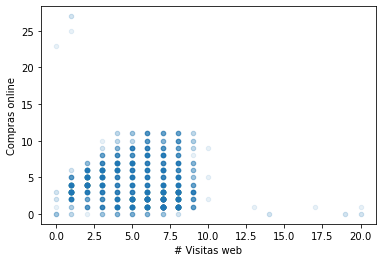

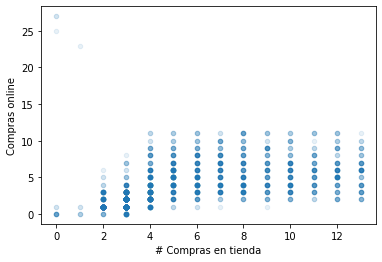

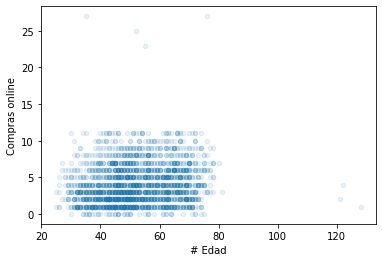

In [114]:

# La utilización de transparencia (alpha) puede ser útil para apreciar la densidad de los datos con tres variables

marketing_data.plot(kind = 'scatter', x='NumWebVisitsMonth', y = 'NumWebPurchases', alpha=0.1)
plt.xlabel('# Visitas web')
plt.ylabel('Compras online')
plt.show()

marketing_data.plot(kind = 'scatter', x='NumStorePurchases', y = 'NumWebPurchases', alpha=0.1)
plt.xlabel('# Compras en tienda')
plt.ylabel('Compras online')
plt.show()

marketing_data.plot(kind = 'scatter', x='years_old', y = 'NumWebPurchases', alpha=0.1)
plt.xlabel('# Edad')
plt.ylabel('Compras online')
plt.show()


Personas menores de 80 años

In [115]:
# por el momento vamos a centrarnos en personas menores de 80 años
sel = marketing_data.years_old <= 80

print(marketing_data.shape)
marketing_data = marketing_data[sel]
print(marketing_data.shape)
marketing_data.head(5)

(2240, 28)
(2236, 28)


,NumWebPurchases,Year_Birth,Education,Marital_Status,Income,Kidhome,Teenhome,Dt_Customer,Recency,MntWines,...,NumWebVisitsMonth,AcceptedCmp3,AcceptedCmp4,AcceptedCmp5,AcceptedCmp1,AcceptedCmp2,Response,Complain,Country,years_old
0,4,1970,Graduation,Divorced,"$84,835.00",0,0,6/16/14,0,189,...,1,0,0,0,0,0,1,0,SP,51
1,7,1961,Graduation,Single,"$57,091.00",0,0,6/15/14,0,464,...,5,0,0,0,0,1,1,0,CA,60
2,3,1958,Graduation,Married,"$67,267.00",0,1,5/13/14,0,134,...,2,0,0,0,0,0,0,0,US,63
3,1,1967,Graduation,Together,"$32,474.00",1,1,5/11/14,0,10,...,7,0,0,0,0,0,0,0,AUS,54
4,3,1989,Graduation,Single,"$21,474.00",1,0,4/8/14,0,6,...,7,1,0,0,0,0,1,0,SP,32


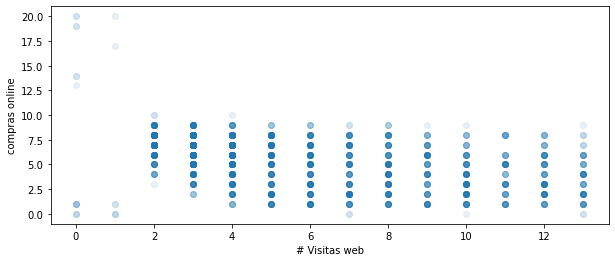

In [116]:
plt.figure(figsize = (10,4))
plt.scatter(marketing_data.NumStorePurchases, marketing_data.NumWebVisitsMonth, alpha=0.1)
plt.xlabel('# Visitas web')
plt.ylabel('compras online')
plt.show()

Calculamos la matriz de correlación:

In [117]:
marketing_data.corr() # matriz de correlación

,NumWebPurchases,Year_Birth,Kidhome,Teenhome,Recency,MntWines,MntFruits,MntMeatProducts,MntFishProducts,MntSweetProducts,...,NumStorePurchases,NumWebVisitsMonth,AcceptedCmp3,AcceptedCmp4,AcceptedCmp5,AcceptedCmp1,AcceptedCmp2,Response,Complain,years_old
NumWebPurchases,1.000000,-0.154622,-0.362275,0.155649,-0.010339,0.542140,0.296947,0.293498,0.293410,0.348235,...,0.502232,-0.056276,0.041911,0.155692,0.138916,0.154952,0.034084,0.148390,-0.013250,0.154622
Year_Birth,-0.154622,1.000000,0.233575,-0.364947,-0.017915,-0.163793,-0.014503,-0.031757,-0.043342,-0.020325,...,-0.140276,0.117585,0.060787,-0.064744,0.015034,-0.008528,-0.007796,0.017987,-0.004590,-1.000000
Kidhome,-0.362275,0.233575,1.000000,-0.036109,0.008148,-0.496643,-0.372826,-0.437436,-0.387890,-0.370990,...,-0.500701,0.447662,0.014505,-0.161908,-0.205132,-0.172638,-0.081849,-0.080346,0.036254,-0.233575
Teenhome,0.155649,-0.364947,-0.036109,1.000000,0.017803,0.005213,-0.176277,-0.261195,-0.204247,-0.162538,...,0.050300,0.134463,-0.042949,0.038680,-0.190383,-0.140426,-0.015715,-0.154941,0.007553,0.364947
Recency,-0.010339,-0.017915,0.008148,0.017803,1.000000,0.017024,-0.003115,0.024236,0.002031,0.023536,...,0.001518,-0.021876,-0.032792,0.019108,0.001160,-0.019079,-0.001680,-0.198388,0.005470,0.017915
MntWines,0.542140,-0.163793,-0.496643,0.005213,0.017024,1.000000,0.388435,0.561934,0.398989,0.385909,...,0.642392,-0.320382,0.062146,0.373497,0.471942,0.354332,0.206027,0.247325,-0.035952,0.163793
MntFruits,0.296947,-0.014503,-0.372826,-0.176277,-0.003115,0.388435,1.000000,0.541961,0.594356,0.566970,...,0.463082,-0.417509,0.014902,0.010319,0.211969,0.195324,-0.009736,0.125798,-0.002828,0.014503
MntMeatProducts,0.293498,-0.031757,-0.437436,-0.261195,0.024236,0.561934,0.541961,1.000000,0.567786,0.523319,...,0.480022,-0.539308,0.018244,0.102977,0.372172,0.310052,0.043058,0.236543,-0.020752,0.031757
MntFishProducts,0.293410,-0.043342,-0.387890,-0.204247,0.002031,0.398989,0.594356,0.567786,1.000000,0.579468,...,0.460009,-0.445849,0.000284,0.016779,0.198101,0.260859,0.002548,0.111302,-0.018849,0.043342
MntSweetProducts,0.348235,-0.020325,-0.370990,-0.162538,0.023536,0.385909,0.566970,0.523319,0.579468,1.000000,...,0.448713,-0.423330,0.001408,0.028532,0.258795,0.241825,0.009939,0.117259,-0.020434,0.020325


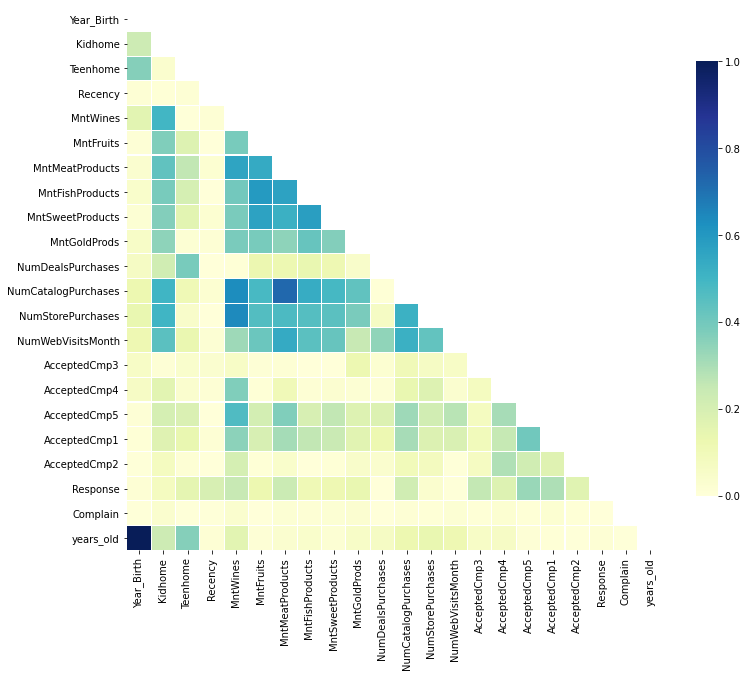

In [118]:
# Compute the correlation matrix
corr = np.abs(marketing_data.drop(['NumWebPurchases'], axis=1).corr())

# Generate a mask for the upper triangle
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(12, 10))

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, vmin = 0.0, vmax=1.0, center=0.5,
            linewidths=.1, cmap="YlGnBu", cbar_kws={"shrink": .8})

plt.show()

Una vez tenemos esta información, es el momento de pensar sobre otras variables que tengan sentido, y de eliminar variables con alta correlación. Algunos ejemplos:

- Eliminar `Year_Birth`
- Utilizar el atributo edad, `years_old`, en lugar del año de nacimiento 

In [122]:
marketing_data = marketing_data.drop(['Year_Birth','Education','Marital_Status','Income','Dt_Customer'], axis=1)
#marketing_data = marketing_data.drop(['Country'], axis=1)
marketing_data.head(5)

,NumWebPurchases,Kidhome,Teenhome,Recency,MntWines,MntFruits,MntMeatProducts,MntFishProducts,MntSweetProducts,MntGoldProds,...,NumStorePurchases,NumWebVisitsMonth,AcceptedCmp3,AcceptedCmp4,AcceptedCmp5,AcceptedCmp1,AcceptedCmp2,Response,Complain,years_old
0,4,0,0,0,189,104,379,111,189,218,...,6,1,0,0,0,0,0,1,0,51
1,7,0,0,0,464,5,64,7,0,37,...,7,5,0,0,0,0,1,1,0,60
2,3,0,1,0,134,11,59,15,2,30,...,5,2,0,0,0,0,0,0,0,63
3,1,1,1,0,10,0,1,0,0,0,...,2,7,0,0,0,0,0,0,0,54
4,3,1,0,0,6,16,24,11,0,34,...,2,7,1,0,0,0,0,1,0,32


/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by the scale function.
  warnings.warn(msg, DataConversionWarning)
/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by the scale function.
  warnings.warn(msg, DataConversionWarning)


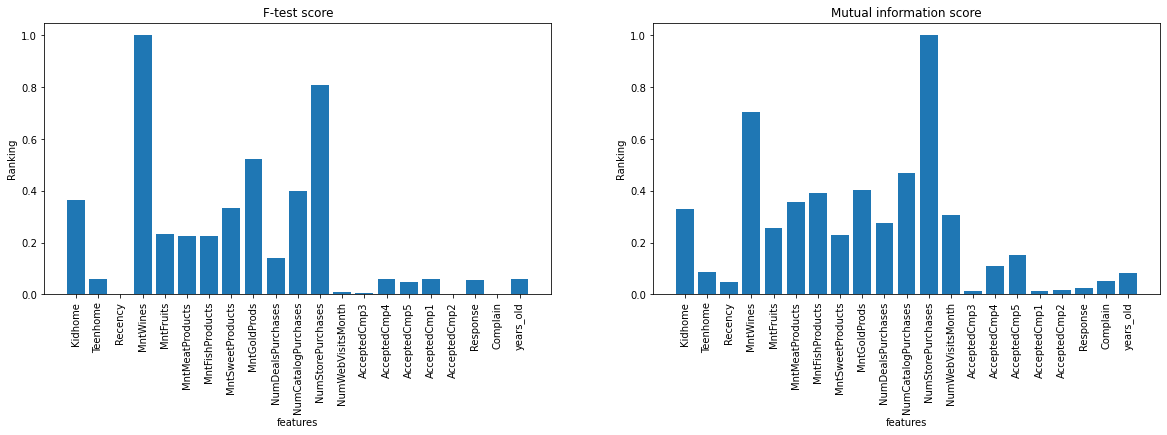

In [124]:
# convertimos el DataFrame al formato necesario para scikit-learn
data = marketing_data.to_numpy()

y = data[:, 0]     # nos quedamos con la 1ª columna, compras por internet
X = data[:,1:]      # nos quedamos con el resto

feature_names = marketing_data.columns[1:]

# do calculations
f_test, _ = f_regression(X, y)
f_test /= np.max(f_test)

mi = mutual_info_regression(X, y)
mi /= np.max(mi)

# do some plotting
plt.figure(figsize=(20, 5))

plt.subplot(1,2,1)
plt.bar(range(X.shape[1]), f_test,  align="center")
plt.xticks(range(X.shape[1]), feature_names, rotation = 90)
plt.xlabel('features')
plt.ylabel('Ranking')
plt.title('F-test score')

plt.subplot(1,2,2)
plt.bar(range(X.shape[1]), mi, align="center")
plt.xticks(range(X.shape[1]), feature_names, rotation = 90)
plt.xlabel('features')
plt.ylabel('Ranking')
plt.title('Mutual information score')

plt.show()

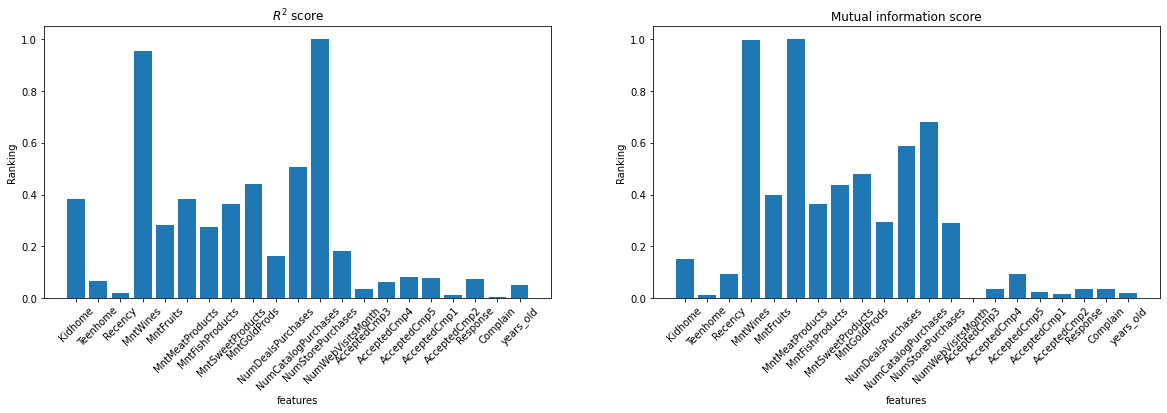

In [125]:
featureNames = marketing_data.columns[1:]


y = data[:, 0]     # nos quedamos con la 1ª columna, price
X = data[:,1:]      # nos quedamos con el resto

# do calculations
f_test, _ = f_classif(X, y)
f_test /= np.max(f_test)

mi = mutual_info_classif(X, y)
mi /= np.max(mi)

# do some plotting
plt.figure(figsize=(20, 5))

plt.subplot(1,2,1)
plt.bar(range(X.shape[1]),f_test,  align="center")
plt.xticks(range(X.shape[1]),featureNames, rotation = 45)
plt.xlabel('features')
plt.ylabel('Ranking')
plt.title('$R^2$ score')

plt.subplot(1,2,2)
plt.bar(range(X.shape[1]),mi,  align="center")
plt.xticks(range(X.shape[1]),featureNames, rotation = 45)
plt.xlabel('features')
plt.ylabel('Ranking')
plt.title('Mutual information score')

plt.show()

/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by the scale function.
  warnings.warn(msg, DataConversionWarning)
/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by the scale function.
  warnings.warn(msg, DataConversionWarning)


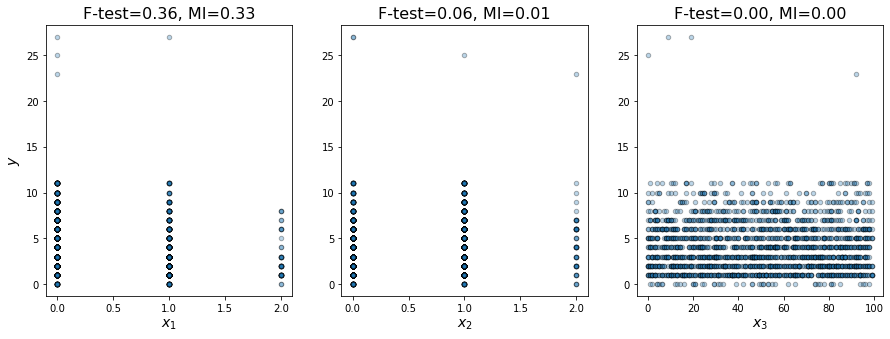

In [126]:
f_test, _ = f_regression(X, y)
f_test /= np.max(f_test)

mi = mutual_info_regression(X, y)
mi /= np.max(mi)


# Dibujamos cómo se relaciona la variable objetivo con cada una de las variables x_i 
plt.figure(figsize=(15, 5))
for i in range(3):
    plt.subplot(1, 3, i + 1)
    plt.scatter(X[:, i], y, edgecolor='black', s=20, alpha=0.3)
    plt.xlabel("$x_{}$".format(i + 1), fontsize=14)
    if i == 0:
        plt.ylabel("$y$", fontsize=14)
    plt.title("F-test={:.2f}, MI={:.2f}".format(f_test[i], mi[i]),
              fontsize=16) # mostramos 
plt.show()